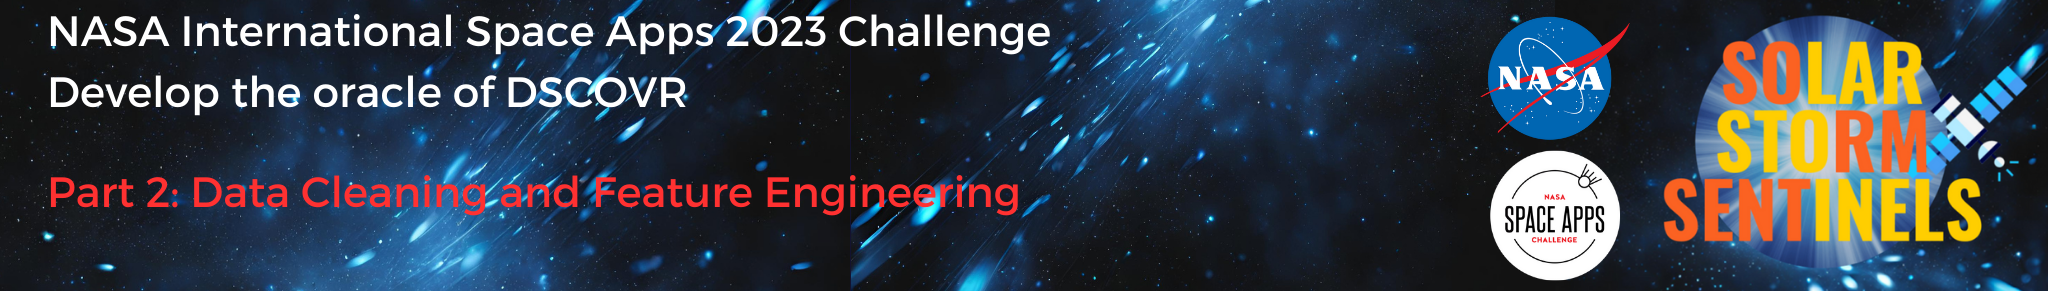

In [1]:
from IPython.display import Image
Image(filename='graphic_design/NASA_part2.png')

At this stage, we have due several activities. First, we have given to the columns names (depending on its procedence: PlasMAG or FC)

We have minute measurements and the Kp index (indicating the expected weather) is usually predicted in 3 hours interval.
After several valuation and considering time constraints and the current intervals of Kp, team has decided to aggregate the data transforming it from minutes to 3 hour interval.

We have created, for the measurements, several statistical features covering the measurments that have taken place inside this 3-hours: mean, range, min, max, median.

As we know, and it is probably the biggest challenge we are dealing with, many of the rows are NaN but they are registered as 0. They could be an anomaly, and they can also be indicator of space weather changes, so the approach of discarding the rows, or filling the NaN with other statistical measurements has been rejected by the group.

In order to tackle this situation, we have:

1- For each 3-hour aggregation, new columns (one per each original variable) have been added in order to account for the proportion of NaN values that each feature presents during that time aggregation. 

2- Additionally, and once all the aggregations have been completed, new columns (one per each aggregated variable) have been added in order to signal the ones that after aggregations contain NaN as value. This is a binary column that is equal to 1 if data is missing and 0 if not missing, so working as an indicator column for missing values. Only at this point, the NaN values have been substituted by zeros.

3- Optionally, we have added the interactions of these binary columns with the rest. However, due to storage and computational limitations, this version of the dataset with interactions could not be used for modelling phase.

## <span style="color: blue">**Table of contents**</span> <a class="anchor"></a>  
- [<span style="color:blue">0. Preparing the environment</span>](#section_0) 
- [<span style="color:blue">1. DSCOVR Data preparation</span>](#toc1_)
    - [<span style="color:blue">1.1. Renaming columns</span>](#toc1_1_)   
    - [<span style="color:blue">1.2. Aggregation based on time</span>](#toc1_2_) 
    - [<span style="color:blue">1.3. Statistical features</span>](#toc1_3_) 
    - [<span style="color:blue">1.4. Dealing with the nulls</span>](#toc1_4_) 
    - [<span style="color:blue">1.5. Export DSCOVR cleaned and grouped data to CSV</span>](#toc1_5_) 
- [<span style="color:blue">2. Kp Data Preparation</span>](#toc2_)
    - [<span style="color:blue">2.1. Preparation</span>](#toc2_1_) 
    - [<span style="color:blue">2.2. Creation of a binned Kp variable for using as classification</span>](#toc2_2_) 
- [<span style="color:blue">3. Merging both dataframes</span>](#toc3_)
- [<span style="color:blue">4. Further preparation on null values</span>](#toc4_)

# <span style="color: blue">**0. Preparing the environment**</span> <a class="anchor" id="section_0"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
list_dscvr_files = [
                    "Raw_data/dsc_fc_summed_spectra_2016_v01.csv",
                    "Raw_data/dsc_fc_summed_spectra_2017_v01.csv",
                    "Raw_data/dsc_fc_summed_spectra_2018_v01.csv",
                    "Raw_data/dsc_fc_summed_spectra_2019_v01.csv",
                    "Raw_data/dsc_fc_summed_spectra_2020_v01.csv",
                    "Raw_data/dsc_fc_summed_spectra_2021_v01.csv",
                    "Raw_data/dsc_fc_summed_spectra_2022_v01.csv",
                    "Raw_data/dsc_fc_summed_spectra_2023_v01.csv"
                    ]

In [3]:
count = 0

for data_file in list_dscvr_files:
    
    if count == 0:
        data_all_init = pd.read_csv(data_file, \
                    delimiter = ',', parse_dates=[0], \
                    infer_datetime_format=True, na_values='0', \
                    header = None)
    
    else:
        data_all_init = pd.concat([data_all_init, pd.read_csv(data_file, \
                    delimiter = ',', parse_dates=[0], \
                    infer_datetime_format=True, na_values='0', \
                    header = None)])
        
    count += 1
    
data_all_init.reset_index(inplace=True, drop=True)

In [4]:
#Removal of initial period up to continuous incoming data from 1st July 2016 (there were a lot of noise there and we can start a bit later without damaging the model)
data_all = data_all_init[18720:]
data_all

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
18720,2016-07-01 00:00:00,-0.259678,6.80223,-2.862570,NaN,NaN,NaN,NaN,NaN,329.849000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18721,2016-07-01 00:01:00,0.602154,7.10539,-2.184250,NaN,NaN,NaN,NaN,NaN,329.560000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18722,2016-07-01 00:02:00,0.517461,6.96508,-2.235470,NaN,NaN,NaN,NaN,NaN,329.845000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18723,2016-07-01 00:03:00,0.809703,6.71474,-2.563130,NaN,NaN,NaN,NaN,NaN,325.738000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18724,2016-07-01 00:04:00,1.148630,6.99785,-1.576800,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3277435,2023-05-02 23:55:00,4.336650,2.80127,0.954633,1.004790,0.231726,4.64757,0.626576,3.54595,0.231726,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3277436,2023-05-02 23:56:00,4.667780,2.10582,1.260660,0.781621,0.231726,5.97222,0.360648,3.39143,0.231726,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3277437,2023-05-02 23:57:00,4.283220,3.02154,0.927773,0.854185,0.231726,8.10454,2.025800,4.22000,0.231726,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3277438,2023-05-02 23:58:00,4.313760,2.67727,1.723270,0.801559,0.231726,12.76210,2.818550,4.82242,0.301864,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# <span style="color: blue">**1. DSCOVR Data preparation**</span> <a class="anchor" id="toc1_"></a>

## <span style="color: blue">**1.1. Renaming columns**</span> <a class="anchor" id="toc1_1_"></a>

In [5]:
dict_mag_field = {0: "datetime_DSCVR", 
                  1: "MagFieldVect_Comp1", 2: "MagFieldVect_Comp2", 3: "MagFieldVect_Comp3"}

In [6]:
key_list = list(range(4,54))
val_list = ["FarCup"+str(i+1) for i in list(range(51))]
iterable = zip(key_list, val_list)
dict_far_cup = {key_list: val_list for key_list,val_list in iterable }

In [7]:
new_dict_DSCVR = {**dict_mag_field, **dict_far_cup}
new_dict_DSCVR

{0: 'datetime_DSCVR',
 1: 'MagFieldVect_Comp1',
 2: 'MagFieldVect_Comp2',
 3: 'MagFieldVect_Comp3',
 4: 'FarCup1',
 5: 'FarCup2',
 6: 'FarCup3',
 7: 'FarCup4',
 8: 'FarCup5',
 9: 'FarCup6',
 10: 'FarCup7',
 11: 'FarCup8',
 12: 'FarCup9',
 13: 'FarCup10',
 14: 'FarCup11',
 15: 'FarCup12',
 16: 'FarCup13',
 17: 'FarCup14',
 18: 'FarCup15',
 19: 'FarCup16',
 20: 'FarCup17',
 21: 'FarCup18',
 22: 'FarCup19',
 23: 'FarCup20',
 24: 'FarCup21',
 25: 'FarCup22',
 26: 'FarCup23',
 27: 'FarCup24',
 28: 'FarCup25',
 29: 'FarCup26',
 30: 'FarCup27',
 31: 'FarCup28',
 32: 'FarCup29',
 33: 'FarCup30',
 34: 'FarCup31',
 35: 'FarCup32',
 36: 'FarCup33',
 37: 'FarCup34',
 38: 'FarCup35',
 39: 'FarCup36',
 40: 'FarCup37',
 41: 'FarCup38',
 42: 'FarCup39',
 43: 'FarCup40',
 44: 'FarCup41',
 45: 'FarCup42',
 46: 'FarCup43',
 47: 'FarCup44',
 48: 'FarCup45',
 49: 'FarCup46',
 50: 'FarCup47',
 51: 'FarCup48',
 52: 'FarCup49',
 53: 'FarCup50'}

In [8]:
DSCVR_data_all = data_all.rename(columns=new_dict_DSCVR)
DSCVR_data_all

,datetime_DSCVR,MagFieldVect_Comp1,MagFieldVect_Comp2,MagFieldVect_Comp3,FarCup1,FarCup2,FarCup3,FarCup4,FarCup5,FarCup6,...,FarCup41,FarCup42,FarCup43,FarCup44,FarCup45,FarCup46,FarCup47,FarCup48,FarCup49,FarCup50
18720,2016-07-01 00:00:00,-0.259678,6.80223,-2.862570,NaN,NaN,NaN,NaN,NaN,329.849000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18721,2016-07-01 00:01:00,0.602154,7.10539,-2.184250,NaN,NaN,NaN,NaN,NaN,329.560000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18722,2016-07-01 00:02:00,0.517461,6.96508,-2.235470,NaN,NaN,NaN,NaN,NaN,329.845000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18723,2016-07-01 00:03:00,0.809703,6.71474,-2.563130,NaN,NaN,NaN,NaN,NaN,325.738000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18724,2016-07-01 00:04:00,1.148630,6.99785,-1.576800,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3277435,2023-05-02 23:55:00,4.336650,2.80127,0.954633,1.004790,0.231726,4.64757,0.626576,3.54595,0.231726,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3277436,2023-05-02 23:56:00,4.667780,2.10582,1.260660,0.781621,0.231726,5.97222,0.360648,3.39143,0.231726,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3277437,2023-05-02 23:57:00,4.283220,3.02154,0.927773,0.854185,0.231726,8.10454,2.025800,4.22000,0.231726,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3277438,2023-05-02 23:58:00,4.313760,2.67727,1.723270,0.801559,0.231726,12.76210,2.818550,4.82242,0.301864,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## <span style="color: blue">**1.2. Aggregation based on time**</span> <a class="anchor" id="toc1_2_"></a>

In [9]:
DSCVR_data_all = DSCVR_data_all.set_index('datetime_DSCVR')
DSCVR_data_all

,MagFieldVect_Comp1,MagFieldVect_Comp2,MagFieldVect_Comp3,FarCup1,FarCup2,FarCup3,FarCup4,FarCup5,FarCup6,FarCup7,...,FarCup41,FarCup42,FarCup43,FarCup44,FarCup45,FarCup46,FarCup47,FarCup48,FarCup49,FarCup50
datetime_DSCVR,,,,,,,,,,,,,,,,,,,,,
2016-07-01 00:00:00,-0.259678,6.80223,-2.862570,NaN,NaN,NaN,NaN,NaN,329.849000,340.556000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 00:01:00,0.602154,7.10539,-2.184250,NaN,NaN,NaN,NaN,NaN,329.560000,343.157000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 00:02:00,0.517461,6.96508,-2.235470,NaN,NaN,NaN,NaN,NaN,329.845000,344.199000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 00:03:00,0.809703,6.71474,-2.563130,NaN,NaN,NaN,NaN,NaN,325.738000,349.640000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 00:04:00,1.148630,6.99785,-1.576800,NaN,NaN,NaN,NaN,NaN,NaN,345.681000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-02 23:55:00,4.336650,2.80127,0.954633,1.004790,0.231726,4.64757,0.626576,3.54595,0.231726,1.795390,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-02 23:56:00,4.667780,2.10582,1.260660,0.781621,0.231726,5.97222,0.360648,3.39143,0.231726,0.506513,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-02 23:57:00,4.283220,3.02154,0.927773,0.854185,0.231726,8.10454,2.025800,4.22000,0.231726,2.344650,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## <span style="color: blue">**1.3. Statistical features**</span> <a class="anchor" id="toc1_3_"></a>

In [10]:
DSCVR_data_all_resampled_mean = DSCVR_data_all.resample('3H', origin='end', offset='1min').mean()
DSCVR_data_all_resampled_mean = DSCVR_data_all_resampled_mean.add_suffix("_mean")
DSCVR_data_all_resampled_mean.head(3)

,MagFieldVect_Comp1_mean,MagFieldVect_Comp2_mean,MagFieldVect_Comp3_mean,FarCup1_mean,FarCup2_mean,FarCup3_mean,FarCup4_mean,FarCup5_mean,FarCup6_mean,FarCup7_mean,...,FarCup41_mean,FarCup42_mean,FarCup43_mean,FarCup44_mean,FarCup45_mean,FarCup46_mean,FarCup47_mean,FarCup48_mean,FarCup49_mean,FarCup50_mean
datetime_DSCVR,,,,,,,,,,,,,,,,,,,,,
2016-07-01 03:00:00,0.265339,3.261504,0.045978,NaN,NaN,NaN,NaN,356.221,333.408857,349.227408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 06:00:00,0.924653,1.763291,-0.228962,NaN,NaN,NaN,NaN,NaN,NaN,351.975857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 09:00:00,-0.770110,2.431628,-1.294382,NaN,NaN,NaN,NaN,NaN,NaN,356.851500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
DSCVR_data_all_resampled_mean

,MagFieldVect_Comp1_mean,MagFieldVect_Comp2_mean,MagFieldVect_Comp3_mean,FarCup1_mean,FarCup2_mean,FarCup3_mean,FarCup4_mean,FarCup5_mean,FarCup6_mean,FarCup7_mean,...,FarCup41_mean,FarCup42_mean,FarCup43_mean,FarCup44_mean,FarCup45_mean,FarCup46_mean,FarCup47_mean,FarCup48_mean,FarCup49_mean,FarCup50_mean
datetime_DSCVR,,,,,,,,,,,,,,,,,,,,,
2016-07-01 03:00:00,0.265339,3.261504,0.045978,NaN,NaN,NaN,NaN,356.221000,333.408857,349.227408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 06:00:00,0.924653,1.763291,-0.228962,NaN,NaN,NaN,NaN,NaN,NaN,351.975857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 09:00:00,-0.770110,2.431628,-1.294382,NaN,NaN,NaN,NaN,NaN,NaN,356.851500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 12:00:00,1.719482,3.512640,-0.144519,NaN,NaN,NaN,NaN,360.279000,340.138000,355.934667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 15:00:00,-1.733990,1.799461,-0.555546,NaN,NaN,NaN,NaN,354.486000,335.147222,348.999882,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-02 12:00:00,4.525159,-0.303902,0.267391,1.263438,0.231726,0.390526,0.231726,0.232078,0.231726,0.231726,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-02 15:00:00,3.567366,1.580780,1.438682,1.263416,0.231726,0.353727,0.231726,0.231726,0.231726,0.231726,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-02 18:00:00,4.230931,0.167467,-0.925729,1.117462,0.231726,0.887621,0.382773,0.446299,0.231726,0.232609,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
DSCVR_data_all_resampled_range = DSCVR_data_all.resample('3H', origin='end', offset='1min').max() - DSCVR_data_all.resample('3H', origin='end', offset='1min').min()
DSCVR_data_all_resampled_range = DSCVR_data_all_resampled_range.add_suffix("_range")
DSCVR_data_all_resampled_range.head(3)

,MagFieldVect_Comp1_range,MagFieldVect_Comp2_range,MagFieldVect_Comp3_range,FarCup1_range,FarCup2_range,FarCup3_range,FarCup4_range,FarCup5_range,FarCup6_range,FarCup7_range,...,FarCup41_range,FarCup42_range,FarCup43_range,FarCup44_range,FarCup45_range,FarCup46_range,FarCup47_range,FarCup48_range,FarCup49_range,FarCup50_range
datetime_DSCVR,,,,,,,,,,,,,,,,,,,,,
2016-07-01 03:00:00,9.90025,11.85823,10.29297,NaN,NaN,NaN,NaN,0.0,27.581,27.507,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 06:00:00,10.31375,14.81710,11.27526,NaN,NaN,NaN,NaN,NaN,NaN,18.328,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 09:00:00,6.40133,10.49359,10.50931,NaN,NaN,NaN,NaN,NaN,NaN,11.028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
DSCVR_data_all_resampled_min = DSCVR_data_all.resample('3H', origin='end', offset='1min').min()
DSCVR_data_all_resampled_min = DSCVR_data_all_resampled_min.add_suffix("_min")
DSCVR_data_all_resampled_min.head(3)

,MagFieldVect_Comp1_min,MagFieldVect_Comp2_min,MagFieldVect_Comp3_min,FarCup1_min,FarCup2_min,FarCup3_min,FarCup4_min,FarCup5_min,FarCup6_min,FarCup7_min,...,FarCup41_min,FarCup42_min,FarCup43_min,FarCup44_min,FarCup45_min,FarCup46_min,FarCup47_min,FarCup48_min,FarCup49_min,FarCup50_min
datetime_DSCVR,,,,,,,,,,,,,,,,,,,,,
2016-07-01 03:00:00,-5.06615,-4.47834,-6.34188,NaN,NaN,NaN,NaN,356.221,325.738,340.556,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 06:00:00,-3.83255,-6.29812,-4.58207,NaN,NaN,NaN,NaN,NaN,NaN,347.105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 09:00:00,-4.19661,-4.68640,-5.97934,NaN,NaN,NaN,NaN,NaN,NaN,352.290,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
DSCVR_data_all_resampled_max = DSCVR_data_all.resample('3H', origin='end', offset='1min').max()
DSCVR_data_all_resampled_max = DSCVR_data_all_resampled_max.add_suffix("_max")
DSCVR_data_all_resampled_max.head(3)

,MagFieldVect_Comp1_max,MagFieldVect_Comp2_max,MagFieldVect_Comp3_max,FarCup1_max,FarCup2_max,FarCup3_max,FarCup4_max,FarCup5_max,FarCup6_max,FarCup7_max,...,FarCup41_max,FarCup42_max,FarCup43_max,FarCup44_max,FarCup45_max,FarCup46_max,FarCup47_max,FarCup48_max,FarCup49_max,FarCup50_max
datetime_DSCVR,,,,,,,,,,,,,,,,,,,,,
2016-07-01 03:00:00,4.83410,7.37989,3.95109,NaN,NaN,NaN,NaN,356.221,353.319,368.063,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 06:00:00,6.48120,8.51898,6.69319,NaN,NaN,NaN,NaN,NaN,NaN,365.433,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 09:00:00,2.20472,5.80719,4.52997,NaN,NaN,NaN,NaN,NaN,NaN,363.318,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
DSCVR_data_all_resampled_median = DSCVR_data_all.resample('3H', origin='end', offset='1min').median()
DSCVR_data_all_resampled_median = DSCVR_data_all_resampled_median.add_suffix("_median")
DSCVR_data_all_resampled_median.head(3)

,MagFieldVect_Comp1_median,MagFieldVect_Comp2_median,MagFieldVect_Comp3_median,FarCup1_median,FarCup2_median,FarCup3_median,FarCup4_median,FarCup5_median,FarCup6_median,FarCup7_median,...,FarCup41_median,FarCup42_median,FarCup43_median,FarCup44_median,FarCup45_median,FarCup46_median,FarCup47_median,FarCup48_median,FarCup49_median,FarCup50_median
datetime_DSCVR,,,,,,,,,,,,,,,,,,,,,
2016-07-01 03:00:00,0.173771,5.75964,0.416581,NaN,NaN,NaN,NaN,356.221,329.849,348.632,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 06:00:00,0.778440,2.24117,-1.765580,NaN,NaN,NaN,NaN,NaN,NaN,348.164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 09:00:00,-0.562646,3.33477,-1.125145,NaN,NaN,NaN,NaN,NaN,NaN,355.899,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## <span style="color: blue">**1.4. Dealing with the nulls**</span> <a class="anchor" id="toc1_4_"></a>

In [16]:
DSCVR_data_all_resampled_nan = DSCVR_data_all.resample('3H', origin='end', offset='1min').apply(lambda x: x.isna().sum() / (x.isna().sum()+x.notna().sum()))
DSCVR_data_all_resampled_nan = DSCVR_data_all_resampled_nan.add_suffix("_nan")
DSCVR_data_all_resampled_nan.head(3)

,MagFieldVect_Comp1_nan,MagFieldVect_Comp2_nan,MagFieldVect_Comp3_nan,FarCup1_nan,FarCup2_nan,FarCup3_nan,FarCup4_nan,FarCup5_nan,FarCup6_nan,FarCup7_nan,...,FarCup41_nan,FarCup42_nan,FarCup43_nan,FarCup44_nan,FarCup45_nan,FarCup46_nan,FarCup47_nan,FarCup48_nan,FarCup49_nan,FarCup50_nan
datetime_DSCVR,,,,,,,,,,,,,,,,,,,,,
2016-07-01 03:00:00,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.994475,0.961326,0.580110,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016-07-01 06:00:00,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.000000,1.000000,0.961111,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016-07-01 09:00:00,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.000000,1.000000,0.977778,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [17]:
DSCVR_data_all_resampled = pd.concat([
                                        DSCVR_data_all_resampled_mean, 
                                        DSCVR_data_all_resampled_range, 
                                        DSCVR_data_all_resampled_min,
                                        DSCVR_data_all_resampled_max,
                                        DSCVR_data_all_resampled_median,
                                        DSCVR_data_all_resampled_nan], axis=1)
DSCVR_data_all_resampled

,MagFieldVect_Comp1_mean,MagFieldVect_Comp2_mean,MagFieldVect_Comp3_mean,FarCup1_mean,FarCup2_mean,FarCup3_mean,FarCup4_mean,FarCup5_mean,FarCup6_mean,FarCup7_mean,...,FarCup41_nan,FarCup42_nan,FarCup43_nan,FarCup44_nan,FarCup45_nan,FarCup46_nan,FarCup47_nan,FarCup48_nan,FarCup49_nan,FarCup50_nan
datetime_DSCVR,,,,,,,,,,,,,,,,,,,,,
2016-07-01 03:00:00,0.265339,3.261504,0.045978,NaN,NaN,NaN,NaN,356.221000,333.408857,349.227408,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016-07-01 06:00:00,0.924653,1.763291,-0.228962,NaN,NaN,NaN,NaN,NaN,NaN,351.975857,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016-07-01 09:00:00,-0.770110,2.431628,-1.294382,NaN,NaN,NaN,NaN,NaN,NaN,356.851500,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016-07-01 12:00:00,1.719482,3.512640,-0.144519,NaN,NaN,NaN,NaN,360.279000,340.138000,355.934667,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016-07-01 15:00:00,-1.733990,1.799461,-0.555546,NaN,NaN,NaN,NaN,354.486000,335.147222,348.999882,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-02 12:00:00,4.525159,-0.303902,0.267391,1.263438,0.231726,0.390526,0.231726,0.232078,0.231726,0.231726,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2023-05-02 15:00:00,3.567366,1.580780,1.438682,1.263416,0.231726,0.353727,0.231726,0.231726,0.231726,0.231726,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2023-05-02 18:00:00,4.230931,0.167467,-0.925729,1.117462,0.231726,0.887621,0.382773,0.446299,0.231726,0.232609,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [18]:
DSCVR_data_all_res_cleaned = DSCVR_data_all_resampled.dropna(axis=0, how='all')
DSCVR_data_all_res_cleaned

,MagFieldVect_Comp1_mean,MagFieldVect_Comp2_mean,MagFieldVect_Comp3_mean,FarCup1_mean,FarCup2_mean,FarCup3_mean,FarCup4_mean,FarCup5_mean,FarCup6_mean,FarCup7_mean,...,FarCup41_nan,FarCup42_nan,FarCup43_nan,FarCup44_nan,FarCup45_nan,FarCup46_nan,FarCup47_nan,FarCup48_nan,FarCup49_nan,FarCup50_nan
datetime_DSCVR,,,,,,,,,,,,,,,,,,,,,
2016-07-01 03:00:00,0.265339,3.261504,0.045978,NaN,NaN,NaN,NaN,356.221000,333.408857,349.227408,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016-07-01 06:00:00,0.924653,1.763291,-0.228962,NaN,NaN,NaN,NaN,NaN,NaN,351.975857,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016-07-01 09:00:00,-0.770110,2.431628,-1.294382,NaN,NaN,NaN,NaN,NaN,NaN,356.851500,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016-07-01 12:00:00,1.719482,3.512640,-0.144519,NaN,NaN,NaN,NaN,360.279000,340.138000,355.934667,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016-07-01 15:00:00,-1.733990,1.799461,-0.555546,NaN,NaN,NaN,NaN,354.486000,335.147222,348.999882,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-02 12:00:00,4.525159,-0.303902,0.267391,1.263438,0.231726,0.390526,0.231726,0.232078,0.231726,0.231726,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2023-05-02 15:00:00,3.567366,1.580780,1.438682,1.263416,0.231726,0.353727,0.231726,0.231726,0.231726,0.231726,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2023-05-02 18:00:00,4.230931,0.167467,-0.925729,1.117462,0.231726,0.887621,0.382773,0.446299,0.231726,0.232609,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [19]:
DSCVR_data_all_res_cleaned[8750:8760]

,MagFieldVect_Comp1_mean,MagFieldVect_Comp2_mean,MagFieldVect_Comp3_mean,FarCup1_mean,FarCup2_mean,FarCup3_mean,FarCup4_mean,FarCup5_mean,FarCup6_mean,FarCup7_mean,...,FarCup41_nan,FarCup42_nan,FarCup43_nan,FarCup44_nan,FarCup45_nan,FarCup46_nan,FarCup47_nan,FarCup48_nan,FarCup49_nan,FarCup50_nan
datetime_DSCVR,,,,,,,,,,,,,,,,,,,,,
2020-02-26 18:00:00,0.057532,-0.254038,-0.497597,629.222667,628.467333,630.909667,628.948667,627.969333,629.806333,629.279000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-02-26 21:00:00,-0.377548,1.416979,-0.805026,55.118700,14.820400,80.550700,64.755821,93.396817,85.100179,123.354110,...,0.994444,0.994444,0.994444,0.994444,0.994444,0.994444,0.994444,0.994444,0.994444,0.994444
2020-02-27 00:00:00,1.418748,-2.473019,0.831546,NaN,NaN,NaN,65.510865,99.196142,89.068237,122.627489,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-02-27 03:00:00,1.721849,-0.542375,1.198122,NaN,NaN,NaN,66.093919,97.388297,87.058325,122.635833,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-02-27 06:00:00,2.871883,0.586231,1.402700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-02-27 09:00:00,-0.726109,-1.769797,-1.479757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-02-27 12:00:00,0.523189,-1.327535,-0.338364,NaN,NaN,NaN,NaN,NaN,84.677300,117.233000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-02-27 15:00:00,2.105137,0.074594,0.288201,NaN,NaN,NaN,NaN,89.801118,77.993980,113.084152,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-02-27 18:00:00,1.726170,-1.047209,0.546321,231.310500,74.559850,149.872000,90.908060,92.943830,78.970268,112.915143,...,0.994444,0.994444,0.994444,0.994444,0.994444,0.994444,0.994444,0.994444,0.994444,0.994444


## <span style="color: blue">**1.5. Export DSCOVR cleaned and grouped data to CSV**</span> <a class="anchor" id="toc1_5_"></a>

In [20]:
DSCVR_data_all_res_cleaned.to_csv("DSCVR_data_all_res_cleaned.csv")

In [21]:
DSCVR_data_all_res_cleaned.isna().sum(axis=0)

MagFieldVect_Comp1_mean      36
MagFieldVect_Comp2_mean      36
MagFieldVect_Comp3_mean      36
FarCup1_mean               8796
FarCup2_mean               8267
                           ... 
FarCup46_nan                  0
FarCup47_nan                  0
FarCup48_nan                  0
FarCup49_nan                  0
FarCup50_nan                  0
Length: 318, dtype: int64

# <span style="color: blue">**2. Kp Data Preparation**</span> <a class="anchor" id="toc2_"></a>

## <span style="color: blue">**2.1. Preparation**</span> <a class="anchor" id="toc2_1_"></a>

In [22]:

'''
list_Kp_SN_files = [
                    "Kp_ap_Ap_SN_F107_2016.txt",
                    "Kp_ap_Ap_SN_F107_2017.txt",
                    "Kp_ap_Ap_SN_F107_2018.txt",
                    "Kp_ap_Ap_SN_F107_2019.txt",
                    "Kp_ap_Ap_SN_F107_2020.txt",
                    "Kp_ap_Ap_SN_F107_2021.txt",
                    "Kp_ap_Ap_SN_F107_2022.txt",
                    "Kp_ap_Ap_SN_F107_2023.txt"
                    ]
'''
list_Kp_files = [
                    "Raw_data/Kp_ap_2016.txt",
                    "Raw_data/Kp_ap_2017.txt",
                    "Raw_data/Kp_ap_2018.txt",
                    "Raw_data/Kp_ap_2019.txt",
                    "Raw_data/Kp_ap_2020.txt",
                    "Raw_data/Kp_ap_2021.txt",
                    "Raw_data/Kp_ap_2022.txt",
                    "Raw_data/Kp_ap_2023.txt"
                    ]


In [23]:
header_Kp_files = ["YYY", "MM", "DD", "hh.h", "hh._m", "days", "days_m", 
                   "Kp", "ap", "D"]

In [24]:
header_Kp_SN_files = ["YYY", "MM", "DD", "days", "days_m", "Bsr", "dB", 
                   "Kp1", "Kp2", "Kp3","Kp4","Kp5","Kp6","Kp7","Kp8",
                   "ap1","ap2","ap3","ap4","ap5","ap6","ap7","ap8",
                   "Ap","SN","F10.7obs","F10.7adj","D"]

In [25]:
# Initialize empty lists to store text content and data separately
text_content = []
data_content = []

def read_txt_file(name_file):

    with open(name_file, 'r') as file:
        lines = file.readlines()
        text_content = lines[:30] # 30 to remove text that is only content, no data
        data_content = lines[30:]

    # Process and print the text content
    text_content = "".join(text_content) # Collect content, but not used below

    # Process the data content
    data = []
    for line in data_content:
        split_line = [float(i) if i.replace('.','',1).isdigit() else i for i in line.split()]
        data.append(split_line)

    df_data = pd.DataFrame(data)

    return df_data

In [26]:
count = 0

for KP_data_file in list_Kp_files:
    
    if count == 0:
        KP_data_all = read_txt_file(KP_data_file) 
    
    else:
        KP_data_all = pd.concat([KP_data_all, read_txt_file(KP_data_file) ])
        
    count += 1
    
KP_data_all.reset_index(inplace=True, drop=True)

In [27]:
KP_data_all

,0,1,2,3,4,5,6,7,8,9
0,2016.0,1.0,1.0,0.0,1.5,30681.000,30681.0625,6.000,80.0,1.0
1,2016.0,1.0,1.0,3.0,4.5,30681.125,30681.1875,5.333,56.0,1.0
2,2016.0,1.0,1.0,6.0,7.5,30681.250,30681.3125,5.000,48.0,1.0
3,2016.0,1.0,1.0,9.0,10.5,30681.375,30681.4375,3.333,18.0,1.0
4,2016.0,1.0,1.0,12.0,13.5,30681.500,30681.5625,1.667,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...
22683,2023.0,10.0,6.0,9.0,10.5,33516.375,33516.4375,1.333,5.0,0.0
22684,2023.0,10.0,6.0,12.0,13.5,33516.500,33516.5625,1.000,4.0,0.0
22685,2023.0,10.0,6.0,15.0,16.5,33516.625,33516.6875,1.333,5.0,0.0
22686,2023.0,10.0,6.0,18.0,19.5,33516.750,33516.8125,0.667,3.0,0.0


In [28]:
key_list = list(range(0,10))
val_list = header_Kp_files
iterable = zip(key_list, val_list)
dict_Kp = {key_list: val_list for key_list,val_list in iterable }
KP_data_all = KP_data_all.rename(columns=dict_Kp)
KP_data_all.head(3)

,YYY,MM,DD,hh.h,hh._m,days,days_m,Kp,ap,D
0,2016.0,1.0,1.0,0.0,1.5,30681.000,30681.0625,6.000,80.0,1.0
1,2016.0,1.0,1.0,3.0,4.5,30681.125,30681.1875,5.333,56.0,1.0
2,2016.0,1.0,1.0,6.0,7.5,30681.250,30681.3125,5.000,48.0,1.0


In [29]:
KP_data_all['hh.h'] = KP_data_all.apply(lambda x: "0"+str(int(x["hh.h"])) if len(str(int(x["hh.h"])))==1 else str(int(x["hh.h"])), axis=1)
KP_data_all['MM'] = KP_data_all.apply(lambda x: "0"+str(int(x["MM"])) if len(str(int(x["MM"])))==1 else str(int(x["MM"])), axis=1)
KP_data_all['DD'] = KP_data_all.apply(lambda x: "0"+str(int(x["DD"])) if len(str(int(x["DD"])))==1 else str(int(x["DD"])), axis=1)
KP_data_all['KP_datetime_init'] = KP_data_all.apply(lambda x: str(int(x['YYY'])) +'-'+ x['MM']+'-'+ x['DD'] +" "+ x['hh.h'] +":"+"00"+":"+"00", axis=1)
KP_data_all['KP_datetime_init'] = pd.to_datetime(KP_data_all['KP_datetime_init'], format="%Y-%m-%d %H:%M:%S")
KP_data_all = KP_data_all[['KP_datetime_init','Kp','ap']]
KP_data_all = KP_data_all.replace(-1, np.nan).copy()
KP_data_all = KP_data_all.replace(-1.000, np.nan).copy()
KP_data_all.reset_index(inplace=True, drop=True)
KP_data_all.head(3)

,KP_datetime_init,Kp,ap
0,2016-01-01 00:00:00,6.000,80.0
1,2016-01-01 03:00:00,5.333,56.0
2,2016-01-01 06:00:00,5.000,48.0


In [30]:
KP_data_all.tail(5)

,KP_datetime_init,Kp,ap
22683,2023-10-06 09:00:00,1.333,5.0
22684,2023-10-06 12:00:00,1.000,4.0
22685,2023-10-06 15:00:00,1.333,5.0
22686,2023-10-06 18:00:00,0.667,3.0
22687,2023-10-06 21:00:00,3.000,15.0


In [31]:
KP_data_all = KP_data_all.set_index('KP_datetime_init')
KP_data_all

,Kp,ap
KP_datetime_init,,
2016-01-01 00:00:00,6.000,80.0
2016-01-01 03:00:00,5.333,56.0
2016-01-01 06:00:00,5.000,48.0
2016-01-01 09:00:00,3.333,18.0
2016-01-01 12:00:00,1.667,6.0
...,...,...
2023-10-06 09:00:00,1.333,5.0
2023-10-06 12:00:00,1.000,4.0
2023-10-06 15:00:00,1.333,5.0


In [32]:
KP_data_all.isna().sum(axis=0)

Kp    0
ap    0
dtype: int64

## <span style="color: blue">**2.2. Creation of a binned Kp variable for using as classification**</span> <a class="anchor" id="toc2_2_"></a>

<AxesSubplot:>

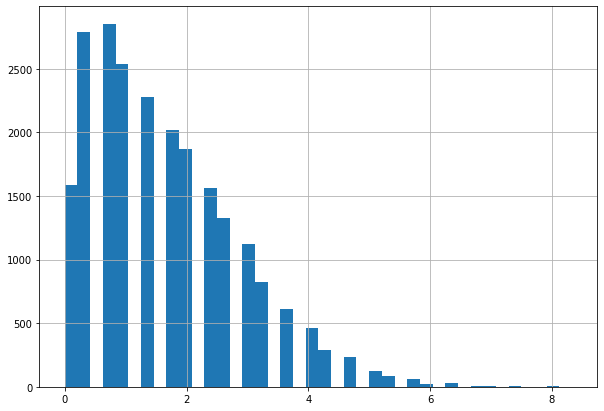

In [33]:
plt.figure(figsize=(10,7))
KP_data_all['Kp'].hist(bins=40)

In [34]:
int(max(KP_data_all['Kp']))

8

In [35]:
KP_data_all['Kp_class'] = KP_data_all.apply(lambda x: int(x['Kp']), axis=1)

In [36]:
KP_data_all['Kp_class'] 

KP_datetime_init
2016-01-01 00:00:00    6
2016-01-01 03:00:00    5
2016-01-01 06:00:00    5
2016-01-01 09:00:00    3
2016-01-01 12:00:00    1
                      ..
2023-10-06 09:00:00    1
2023-10-06 12:00:00    1
2023-10-06 15:00:00    1
2023-10-06 18:00:00    0
2023-10-06 21:00:00    3
Name: Kp_class, Length: 22688, dtype: int64

<AxesSubplot:>

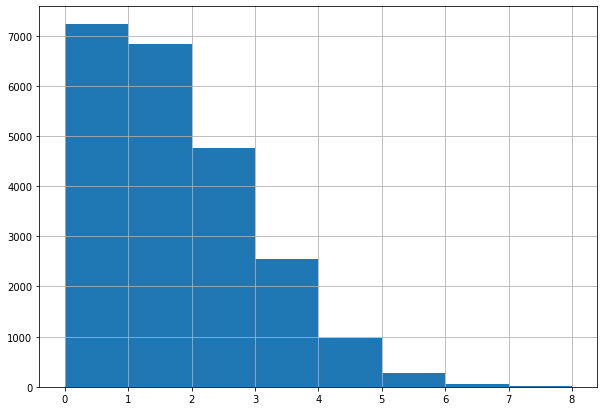

In [37]:
plt.figure(figsize=(10,7))
KP_data_all['Kp_class'].hist(bins=8)

# <span style="color: blue">**3. Merging both datafranes**</span> <a class="anchor" id="toc3_"></a>

In [38]:
DSCVR_KP_all_cleaned = DSCVR_data_all_res_cleaned.join(KP_data_all)
DSCVR_KP_all_cleaned

,MagFieldVect_Comp1_mean,MagFieldVect_Comp2_mean,MagFieldVect_Comp3_mean,FarCup1_mean,FarCup2_mean,FarCup3_mean,FarCup4_mean,FarCup5_mean,FarCup6_mean,FarCup7_mean,...,FarCup44_nan,FarCup45_nan,FarCup46_nan,FarCup47_nan,FarCup48_nan,FarCup49_nan,FarCup50_nan,Kp,ap,Kp_class
datetime_DSCVR,,,,,,,,,,,,,,,,,,,,,
2016-07-01 03:00:00,0.265339,3.261504,0.045978,NaN,NaN,NaN,NaN,356.221000,333.408857,349.227408,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.000,7.0,2
2016-07-01 06:00:00,0.924653,1.763291,-0.228962,NaN,NaN,NaN,NaN,NaN,NaN,351.975857,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.333,9.0,2
2016-07-01 09:00:00,-0.770110,2.431628,-1.294382,NaN,NaN,NaN,NaN,NaN,NaN,356.851500,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.000,7.0,2
2016-07-01 12:00:00,1.719482,3.512640,-0.144519,NaN,NaN,NaN,NaN,360.279000,340.138000,355.934667,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.333,5.0,1
2016-07-01 15:00:00,-1.733990,1.799461,-0.555546,NaN,NaN,NaN,NaN,354.486000,335.147222,348.999882,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.667,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-02 12:00:00,4.525159,-0.303902,0.267391,1.263438,0.231726,0.390526,0.231726,0.232078,0.231726,0.231726,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,4.0,1
2023-05-02 15:00:00,3.567366,1.580780,1.438682,1.263416,0.231726,0.353727,0.231726,0.231726,0.231726,0.231726,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,4.0,1
2023-05-02 18:00:00,4.230931,0.167467,-0.925729,1.117462,0.231726,0.887621,0.382773,0.446299,0.231726,0.232609,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.667,6.0,1


In [ ]:
#Merged DSCVR + KP Export to CSV
DSCVR_KP_all_cleaned.to_csv("DSCVR_KP_all_cleaned.csv")

### Analysis of NaN in each column

In [40]:
for columni in list(DSCVR_KP_all_cleaned.columns):
    
    print(columni + " :" + str(DSCVR_KP_all_cleaned[columni].isna().sum()))

MagFieldVect_Comp1_mean :36
MagFieldVect_Comp2_mean :36
MagFieldVect_Comp3_mean :36
FarCup1_mean :8796
FarCup2_mean :8267
FarCup3_mean :7409
FarCup4_mean :6775
FarCup5_mean :6106
FarCup6_mean :5474
FarCup7_mean :4843
FarCup8_mean :4264
FarCup9_mean :3672
FarCup10_mean :3240
FarCup11_mean :2777
FarCup12_mean :2467
FarCup13_mean :2158
FarCup14_mean :1868
FarCup15_mean :1632
FarCup16_mean :1419
FarCup17_mean :1167
FarCup18_mean :1053
FarCup19_mean :990
FarCup20_mean :1268
FarCup21_mean :1477
FarCup22_mean :2231
FarCup23_mean :2637
FarCup24_mean :3404
FarCup25_mean :4036
FarCup26_mean :4999
FarCup27_mean :5778
FarCup28_mean :7037
FarCup29_mean :7559
FarCup30_mean :9006
FarCup31_mean :9520
FarCup32_mean :10192
FarCup33_mean :11197
FarCup34_mean :11796
FarCup35_mean :12264
FarCup36_mean :13207
FarCup37_mean :13560
FarCup38_mean :14686
FarCup39_mean :15034
FarCup40_mean :15447
FarCup41_mean :15915
FarCup42_mean :16258
FarCup43_mean :16470
FarCup44_mean :16879
FarCup45_mean :16955
FarCup46_mea

(array([  2.,   1.,   2.,   1.,   0.,   2.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   2.,   1.,   1.,   2.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   1.,   1.,   2.,   1.,   1.,   1.,   1.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   1.,
          0.,   1.,   0.,   1.,   1.,   0.,   1.,   1.,   1.,   0.,   0.,
          1.,   1.,   0.,   0.,   1.,   2.,   1.,   1.,   2.,   2.,   0.,
          1.,   2.,   1.,   1.,   3.,   3.,   1.,   3.,   6.,   3.,   2.,
          1.,   1.,   2.,   3.,   5.,   4.,   2.,   7.,   6.,   5.,   5.,
          3.,   6.,   8.,   5.,   8.,   5.,   6.,   7.,   5.,  10.,  10.,
         10.,  10.,  10.,  12.,   8.,   5.,   9.,   7.,   7.,  11.,   8.,
         16.,   5.,  11.,  11.,  21.,   9.,  11.,  19.,  17.,  25.,  29.,
         23.,  33.,  28.,  32.,  16.,  30.,  45.,  30.,  39.,  44.,  50.,
         46.,  64.,  57.,  48.,  58.,  67.,  54.,  77.,  85.,  91.,  99.,
        116., 119., 118., 119., 138., 

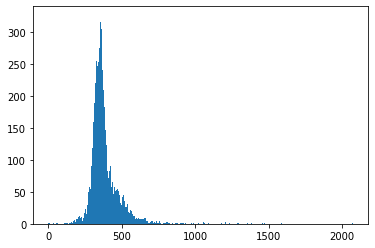

In [41]:
plt.hist(DSCVR_KP_all_cleaned["FarCup18_mean"], bins=1000)

## <span style="color: blue">**4. Further preparation on null values**</span> <a class="anchor" id="toc4_"></a>

- It is the purpose of creating a missing value column (yes=1, no=0) for each variable (vF1, vF2)
- Once the above is done a value of 0 is imputed for the missing value (vF1, vF2)
- Finally, and optionally (vF2) new interaction columns between each of the binary missing value with the rest of the columns is created.
- Note this expands exponentially the number of variables (vF2), that's why we are keeping a version without interactions (vF1) 

In [42]:
DSCVR_KP_all_cleaned_extended = DSCVR_KP_all_cleaned.copy()
DSCVR_KP_all_cleaned_extended_vF1 = DSCVR_KP_all_cleaned.copy()  # only binary missing value columns
DSCVR_KP_all_cleaned_extended_vF2 = DSCVR_KP_all_cleaned.copy()  # binary missing value columns + interactions

In [43]:
np.isnan(DSCVR_KP_all_cleaned_extended['FarCup1_mean'][0])

True

In [44]:
total_iter = len(list(DSCVR_KP_all_cleaned_extended.columns[0:53]))*(-1+len(list(DSCVR_KP_all_cleaned_extended.columns.difference(['Kp','ap','Kp_class']))))
total_iter

16801

In [45]:
count = 0
for columnx in list(DSCVR_KP_all_cleaned_extended.columns[0:53]):
    DSCVR_KP_all_cleaned_extended_vF1[columnx + "_MISSING"] = DSCVR_KP_all_cleaned_extended_vF1.apply(lambda x: 1 if np.isnan(x[columnx]) else 0, axis=1)
    DSCVR_KP_all_cleaned_extended_vF1.fillna(0, inplace=True)
    DSCVR_KP_all_cleaned_extended_vF2[columnx + "_MISSING"] = DSCVR_KP_all_cleaned_extended_vF2.apply(lambda x: 1 if np.isnan(x[columnx]) else 0, axis=1)
    DSCVR_KP_all_cleaned_extended_vF2.fillna(0, inplace=True)
    countx=0
    for columny in list(DSCVR_KP_all_cleaned_extended.columns.difference(['Kp','ap','Kp_class', columnx])):
        DSCVR_KP_all_cleaned_extended_vF2['INT_MISSING_'+ columny + "__" + columnx] = (DSCVR_KP_all_cleaned_extended_vF2[columnx + "_MISSING"] * DSCVR_KP_all_cleaned_extended_vF2[columny]).copy()
        count +=1
        countx +=1
        #print("column X:", columnx, "column Y: ", columny, "Count X: ", countx, "TOTAL COUNT: ", count)
# DSCVR_KP_all_cleaned_extended

In [46]:
DSCVR_KP_all_cleaned_extended_vF1.head(3)

,MagFieldVect_Comp1_mean,MagFieldVect_Comp2_mean,MagFieldVect_Comp3_mean,FarCup1_mean,FarCup2_mean,FarCup3_mean,FarCup4_mean,FarCup5_mean,FarCup6_mean,FarCup7_mean,...,FarCup41_mean_MISSING,FarCup42_mean_MISSING,FarCup43_mean_MISSING,FarCup44_mean_MISSING,FarCup45_mean_MISSING,FarCup46_mean_MISSING,FarCup47_mean_MISSING,FarCup48_mean_MISSING,FarCup49_mean_MISSING,FarCup50_mean_MISSING
datetime_DSCVR,,,,,,,,,,,,,,,,,,,,,
2016-07-01 03:00:00,0.265339,3.261504,0.045978,0.0,0.0,0.0,0.0,356.221,333.408857,349.227408,...,0,0,0,0,0,0,0,0,0,0
2016-07-01 06:00:00,0.924653,1.763291,-0.228962,0.0,0.0,0.0,0.0,0.000,0.000000,351.975857,...,0,0,0,0,0,0,0,0,0,0
2016-07-01 09:00:00,-0.770110,2.431628,-1.294382,0.0,0.0,0.0,0.0,0.000,0.000000,356.851500,...,0,0,0,0,0,0,0,0,0,0


In [47]:
DSCVR_KP_all_cleaned_extended_vF2.head(3)

,MagFieldVect_Comp1_mean,MagFieldVect_Comp2_mean,MagFieldVect_Comp3_mean,FarCup1_mean,FarCup2_mean,FarCup3_mean,FarCup4_mean,FarCup5_mean,FarCup6_mean,FarCup7_mean,...,INT_MISSING_MagFieldVect_Comp2_median__FarCup50_mean,INT_MISSING_MagFieldVect_Comp2_min__FarCup50_mean,INT_MISSING_MagFieldVect_Comp2_nan__FarCup50_mean,INT_MISSING_MagFieldVect_Comp2_range__FarCup50_mean,INT_MISSING_MagFieldVect_Comp3_max__FarCup50_mean,INT_MISSING_MagFieldVect_Comp3_mean__FarCup50_mean,INT_MISSING_MagFieldVect_Comp3_median__FarCup50_mean,INT_MISSING_MagFieldVect_Comp3_min__FarCup50_mean,INT_MISSING_MagFieldVect_Comp3_nan__FarCup50_mean,INT_MISSING_MagFieldVect_Comp3_range__FarCup50_mean
datetime_DSCVR,,,,,,,,,,,,,,,,,,,,,
2016-07-01 03:00:00,0.265339,3.261504,0.045978,0.0,0.0,0.0,0.0,356.221,333.408857,349.227408,...,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0
2016-07-01 06:00:00,0.924653,1.763291,-0.228962,0.0,0.0,0.0,0.0,0.000,0.000000,351.975857,...,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0
2016-07-01 09:00:00,-0.770110,2.431628,-1.294382,0.0,0.0,0.0,0.0,0.000,0.000000,356.851500,...,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0


In [48]:
DSCVR_KP_all_cleaned_extended_fp32_vF2 = DSCVR_KP_all_cleaned_extended_vF2.astype('float32')
DSCVR_KP_all_cleaned_extended_fp32_vF2.head(3)

,MagFieldVect_Comp1_mean,MagFieldVect_Comp2_mean,MagFieldVect_Comp3_mean,FarCup1_mean,FarCup2_mean,FarCup3_mean,FarCup4_mean,FarCup5_mean,FarCup6_mean,FarCup7_mean,...,INT_MISSING_MagFieldVect_Comp2_median__FarCup50_mean,INT_MISSING_MagFieldVect_Comp2_min__FarCup50_mean,INT_MISSING_MagFieldVect_Comp2_nan__FarCup50_mean,INT_MISSING_MagFieldVect_Comp2_range__FarCup50_mean,INT_MISSING_MagFieldVect_Comp3_max__FarCup50_mean,INT_MISSING_MagFieldVect_Comp3_mean__FarCup50_mean,INT_MISSING_MagFieldVect_Comp3_median__FarCup50_mean,INT_MISSING_MagFieldVect_Comp3_min__FarCup50_mean,INT_MISSING_MagFieldVect_Comp3_nan__FarCup50_mean,INT_MISSING_MagFieldVect_Comp3_range__FarCup50_mean
datetime_DSCVR,,,,,,,,,,,,,,,,,,,,,
2016-07-01 03:00:00,0.265339,3.261504,0.045978,0.0,0.0,0.0,0.0,356.221008,333.408844,349.227417,...,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0
2016-07-01 06:00:00,0.924653,1.763291,-0.228962,0.0,0.0,0.0,0.0,0.000000,0.000000,351.975861,...,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0
2016-07-01 09:00:00,-0.770110,2.431628,-1.294382,0.0,0.0,0.0,0.0,0.000000,0.000000,356.851501,...,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0


In [49]:
DSCVR_KP_all_cleaned_extended_fp32_vF1 = DSCVR_KP_all_cleaned_extended_vF1.astype('float32')
DSCVR_KP_all_cleaned_extended_fp32_vF1.head(3)

,MagFieldVect_Comp1_mean,MagFieldVect_Comp2_mean,MagFieldVect_Comp3_mean,FarCup1_mean,FarCup2_mean,FarCup3_mean,FarCup4_mean,FarCup5_mean,FarCup6_mean,FarCup7_mean,...,FarCup41_mean_MISSING,FarCup42_mean_MISSING,FarCup43_mean_MISSING,FarCup44_mean_MISSING,FarCup45_mean_MISSING,FarCup46_mean_MISSING,FarCup47_mean_MISSING,FarCup48_mean_MISSING,FarCup49_mean_MISSING,FarCup50_mean_MISSING
datetime_DSCVR,,,,,,,,,,,,,,,,,,,,,
2016-07-01 03:00:00,0.265339,3.261504,0.045978,0.0,0.0,0.0,0.0,356.221008,333.408844,349.227417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-07-01 06:00:00,0.924653,1.763291,-0.228962,0.0,0.0,0.0,0.0,0.000000,0.000000,351.975861,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-07-01 09:00:00,-0.770110,2.431628,-1.294382,0.0,0.0,0.0,0.0,0.000000,0.000000,356.851501,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
#EXPORT TO CSV 
DSCVR_KP_all_cleaned_extended_fp32_vF1.to_csv("DSCVR_KP_all_cleaned_extended_fp32_vF1.csv")
# DSCVR_KP_all_cleaned_extended_fp16_vF2.to_csv("DSCVR_KP_all_cleaned_extended_fp16_vF2.csv") # muy grande para exportar